In [1]:
import os
import copy
import random
import pandas as pd
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms.functional as TF
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder

In [2]:
from os import listdir
from pathlib import Path
def load_dir(dir):
    images = []
    masks = []
    label = []
    resize = T.Resize((128,128))
    for subdir in listdir(dir):
        for file in listdir(f"{dir}/{subdir}"):
            if file.endswith(".png") and "mask" not in file:
                image = read_image(f"{dir}/{subdir}/{file}", ImageReadMode.GRAY)
                image = resize(image)
                image = TF.convert_image_dtype(image, dtype=torch.float32)
                
                filename = file.split(".")[0]
                files_list = list(Path(f"{dir}/{subdir}").rglob(f"{filename}*"))
                masks_list = [f for f in files_list if "mask" in str(f)]

                if len(masks_list) == 1:
                        mask_file = masks_list[0]
                        mask = read_image(f"{mask_file}", ImageReadMode.GRAY)
                        mask = resize(mask)
                        mask = TF.convert_image_dtype(mask, dtype=torch.float32)
                        
                        images.append(image)
                        masks.append(mask)
                        label.append(subdir)
                        
                else:
                    continue
                    
    return images, masks, label

In [3]:
class BUSI_dataset(Dataset):
    def __init__(self, path):
        self.images, self.masks, labels = load_dir(path)
        self.transform = T.Compose([
            T.Normalize(0.5, 0.5),
        ])
        
        encLabel = LabelEncoder().fit_transform(labels)
        self.labels = torch.from_numpy(encLabel)
    
    def __getitem__(self, index):
        return self.transform(self.images[index]), self.transform(self.masks[index]), self.labels[index]
        #return self.images[index], self.masks[index]
    
    def __len__(self):
        return len(self.images)

In [4]:
path = "../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"
dataset = BUSI_dataset(path)
dataLoader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

In [5]:
data = next(iter(dataLoader))
print(data[2], data[2][4])

tensor([1, 0, 0, 0, 1, 2, 1, 2, 1, 0, 1, 0, 0, 2, 1, 0]) tensor(1)


In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
class GenBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(GenBlock, self).__init__()
        
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        
        return self.dropout(self.relu(x))

class DisBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(DisBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        
        return self.dropout(self.relu(x))

In [8]:
##Generator architecture
class Generator(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super(Generator, self).__init__()
        
        self.inBlock = GenBlock(in_channels, mid_channels, kernel_size=4, stride=1, padding=0)  #4x4
        self.net = nn.Sequential(
            GenBlock(mid_channels+1, mid_channels//2, kernel_size=4, stride=2, padding=1),  #8x8
            GenBlock(mid_channels//2, mid_channels//4, kernel_size=4, stride=2, padding=1),  #16x16
            GenBlock(mid_channels//4, mid_channels//8, kernel_size=4, stride=2, padding=1),  #32x32
            GenBlock(mid_channels//8, mid_channels//16, kernel_size=4, stride=2, padding=1),  #64x64
            nn.ConvTranspose2d(mid_channels//16, out_channels, kernel_size=4, stride=2, padding=1),#128x128
            nn.Tanh())
        
        self.embedding = nn.Embedding(3, 50)
        self.linear = nn.Linear(50, 4*4)
        
    def forward(self, x, label):
        y = self.embedding(label)
        y = self.linear(y).view(-1,1,4,4)
        x = self.inBlock(x)
        x = torch.cat((x,y), dim=1)
        return self.net(x)

In [9]:
## Discriminator architecture
class Discriminator(nn.Module):
    def __init__(self, in_channels, mid_channels):
        super(Discriminator, self).__init__()
        
        #self.embedding = nn.Embedding(3, 50)
        #self.inLinear = nn.Linear(50, 128*128)
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            DisBlock(mid_channels, mid_channels*2, 4, 2, 1),
            DisBlock(mid_channels*2, mid_channels*4, 4, 2, 1),
            DisBlock(mid_channels*4, mid_channels*8, 4, 2, 1),
            DisBlock(mid_channels*8, mid_channels*16, 4, 2, 1)
        )
        
        self.Slinear = nn.Linear(mid_channels*16*4*4, 1)
        self.Clinear = nn.Linear(mid_channels*16*4*4, 3)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.net(x)
        x = torch.flatten(x, start_dim=1)
        y1 = self.sigmoid(self.Slinear(x)).view(-1)
        y2 = self.softmax(self.Clinear(x))
        #print(y1.shape, y2.shape)
        return y1, y2

In [10]:
def add_noise(inputs):
    noise = torch.randn_like(inputs)
    return inputs + noise

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nz = 100
GNet = Generator(nz, 1024, 2).to(device)
GNet.apply(weights_init)
DNet = Discriminator(2, 32).to(device)
DNet.apply(weights_init)

optimizerG = optim.Adam(GNet.parameters(), lr=0.00002, betas=(0.5,0.999))
optimizerD = optim.Adam(DNet.parameters(), lr=0.00002, betas=(0.5,0.999))

criterion = nn.BCELoss()
classCriterion = nn.CrossEntropyLoss()

real_label = 1
fake_label = 0

disc_loss = []
gen_loss = []
num_epochs = 200

for e in range(num_epochs):
    dLoss = 0
    gLoss = 0
    
    for i, (image, mask, imgLabel) in enumerate(dataLoader):
        image = torch.squeeze(image)
        mask = torch.squeeze(mask)
        imgLabel = imgLabel.to(device)
        
        B, H, W = image.shape
        real_input = torch.stack((image, mask)).permute(1,0,2,3).to(device)
        real_input = add_noise(real_input)
        #label = torch.full((B,), real_label, dtype=torch.float, device=device)
        label = torch.sub(1.2, 0.5 * torch.rand((B,), dtype=torch.float, device=device))
        
        DNet.zero_grad()
        sOutput, cOutput = DNet(real_input)
        #print(real_input.shape)
        dLoss_real = criterion(sOutput, label) + classCriterion(cOutput, imgLabel)
        
        dLoss_real.backward()
        
        noise = torch.randn(B, nz, 1, 1, device=device)
        noisyLabel = torch.randint(0, 3, (B,), device=device)
        fake_input = GNet(noise, noisyLabel)
        fake_input = add_noise(fake_input)
        #label.fill_(fake_label)
        label = 0.3 * torch.rand((B,), dtype=torch.float, device=device)
        
        sOutput, cOutput = DNet(fake_input.detach())
        dLoss_fake = criterion(sOutput, label) + classCriterion(cOutput, noisyLabel)
        
        dLoss_fake.backward()
        dLoss += dLoss_real + dLoss_fake
        
        optimizerD.step()
        
        GNet.zero_grad()
        #label.fill_(real_label)
        label = torch.sub(1.2, 0.5 * torch.rand((B,), dtype=torch.float, device=device))
        
        #fake_input = GNet(noise)
        sOutput, cOutput = DNet(fake_input)
        gLoss_ = criterion(sOutput, label) + classCriterion(cOutput, noisyLabel)
        gLoss_.backward()
        
        optimizerG.step()
        
        gLoss += gLoss_
    disc_loss.append(dLoss.item())
    gen_loss.append(gLoss.item())
    print('Epoch {:.0f}/{:.0f} : Discriminator loss: {:.4f} | Generator loss: {:.4f}'.format(e+1, num_epochs, dLoss, gLoss))

Epoch 1/200 : Discriminator loss: 175.3207 | Generator loss: 86.8098
Epoch 2/200 : Discriminator loss: 173.0925 | Generator loss: 85.6490
Epoch 3/200 : Discriminator loss: 172.1568 | Generator loss: 85.0835
Epoch 4/200 : Discriminator loss: 170.7041 | Generator loss: 86.9967
Epoch 5/200 : Discriminator loss: 169.1900 | Generator loss: 87.3259
Epoch 6/200 : Discriminator loss: 167.2456 | Generator loss: 87.9185
Epoch 7/200 : Discriminator loss: 165.2597 | Generator loss: 88.1291
Epoch 8/200 : Discriminator loss: 159.1294 | Generator loss: 89.7956
Epoch 9/200 : Discriminator loss: 156.6184 | Generator loss: 96.9851
Epoch 10/200 : Discriminator loss: 150.8963 | Generator loss: 102.0763
Epoch 11/200 : Discriminator loss: 146.4688 | Generator loss: 106.6410
Epoch 12/200 : Discriminator loss: 146.5356 | Generator loss: 109.5364
Epoch 13/200 : Discriminator loss: 151.2799 | Generator loss: 102.0375
Epoch 14/200 : Discriminator loss: 159.6506 | Generator loss: 94.3575
Epoch 15/200 : Discrimina

In [12]:
def show_image(images):
    fig, ax = plt.subplots(figsize=(20,20))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()), nrow=8, normalize=True).permute(1, 2, 0))

In [13]:
def enable_dropout(m):
    for each_module in m.modules():
        if each_module.__class__.__name__.startswith('Dropout'):
            each_module.train()

torch.Size([2, 8, 128, 128])
torch.Size([8, 1, 128, 128])
tensor([2, 1, 1, 2, 0, 0, 2, 1], device='cuda:0')


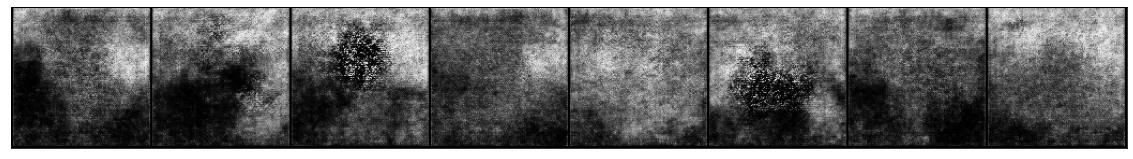

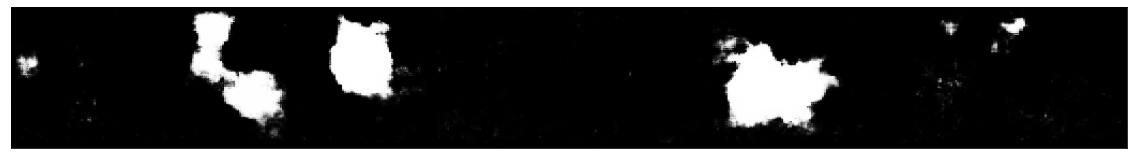

In [14]:
B = 8
with torch.no_grad():
    noise = torch.randn(B,nz,1,1,device=device)
    noisyLabel = torch.randint(0, 3, (B,), device=device)
    GNet.eval()
    enable_dropout(GNet)
    output = GNet(noise, noisyLabel).permute(1,0,2,3).to("cpu")
    print(output.shape)
    images = torch.unsqueeze(output[0],dim=1)
    print(images.shape)
    masks = torch.unsqueeze(output[1],dim=1)
    print(noisyLabel)
    show_image(images)
    show_image(masks)